In [2]:
!pip install torch torchvision basicsr realesrgan lpips
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214819 sha256=f4b32b726c9159ea9b70f0982b814488553a7126e9f691962e3840d117e9b15e
  Stored in directory: /root/.cac

In [3]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from basicsr.archs.rrdbnet_arch import RRDBNet
from torchvision.models import vgg19
import torch.nn.functional as F
import cv2
import os


# Define the paths
model_path = '/content/drive/MyDrive/AI/Term 3/model/RealESRGAN_x2.pth'
lr_image_path = '/content/drive/MyDrive/AI/Term 3/dataset/val/low_res/0.png'
hr_image_path = '/content/drive/MyDrive/AI/Term 3/dataset/val/high_res/0.png'

In [4]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load images
lr_image = Image.open(lr_image_path).convert('RGB')
hr_image = Image.open(hr_image_path).convert('RGB')

lr_image_tensor = transform(lr_image).unsqueeze(0).cuda()
hr_image_tensor = transform(hr_image).unsqueeze(0).cuda()

# Load the model
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=2)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model.cuda()


RRDBNet(
  (conv_first): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (body): Sequential(
    (0): RRDB(
      (rdb1): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv5): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (rdb2): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1),

In [7]:
# Generate super-resolved image
with torch.no_grad():
    sr_image_tensor = model(lr_image_tensor)

# Convert tensors to images for visualization
lr_image_np = lr_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
hr_image_tensor_np = hr_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0) # Convert hr_image_tensor to numpy
sr_image_np = sr_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)

# Resize the super-resolved image to match the high-resolution image
sr_image_np = cv2.resize(sr_image_np, (hr_image_tensor_np.shape[1], hr_image_tensor_np.shape[0]), interpolation=cv2.INTER_CUBIC)

# Convert back to uint8
lr_image_np = (lr_image_np * 255).astype(np.uint8)
hr_image_np = (hr_image_tensor_np * 255).astype(np.uint8) # Use hr_image_tensor_np
sr_image_np = (sr_image_np * 255).astype(np.uint8)

# Calculate PSNR
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

psnr_value = calculate_psnr(sr_image_np, hr_image_np)

# Calculate VGG Loss
class VGGLoss(torch.nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        self.vgg = vgg19(pretrained=True).features[:36].cuda().eval()
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.criterion = torch.nn.L1Loss()

    def forward(self, x, y):
        x_vgg = self.vgg(x)
        y_vgg = self.vgg(y)
        loss = self.criterion(x_vgg, y_vgg)
        return loss

vgg_loss = VGGLoss()
# Resize sr_image_tensor to match hr_image_tensor before calculating VGG loss
sr_image_tensor_resized = F.interpolate(sr_image_tensor, size=hr_image_tensor.shape[2:], mode='bicubic', align_corners=False)
vgg_loss_value = vgg_loss(sr_image_tensor_resized, hr_image_tensor).item()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


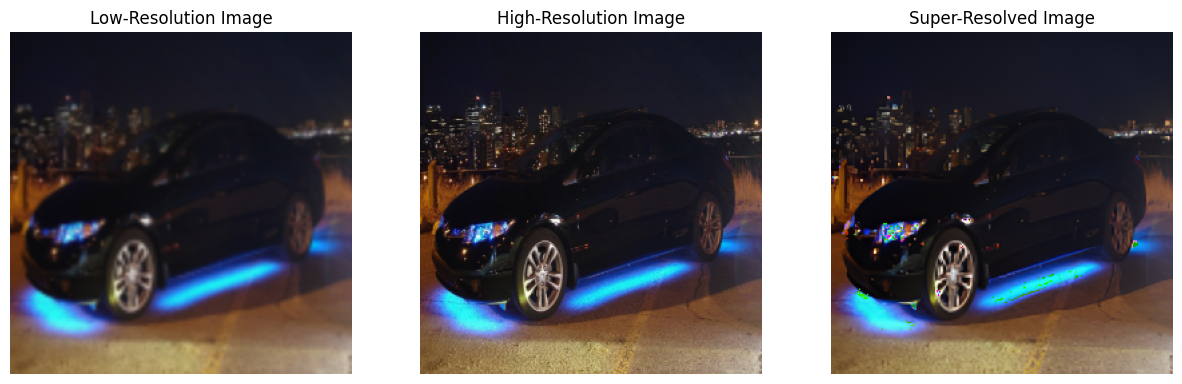

PSNR: 34.16 dB
VGG Loss: 0.0522


In [9]:
# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Low-Resolution Image')
plt.imshow(lr_image_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('High-Resolution Image')
# Use the correct variable for the high-resolution image
plt.imshow(hr_image_np)  # Changed from hr_image_resized_np
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Super-Resolved Image')
plt.imshow(sr_image_np)
plt.axis('off')

plt.show()

print(f'PSNR: {psnr_value:.2f} dB')
print(f'VGG Loss: {vgg_loss_value:.4f}')

In [20]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import os
from basicsr.archs.rrdbnet_arch import RRDBNet
from torchvision.models import vgg19
import torch.nn.functional as F
import cv2

# Define the paths
model_path = '/content/drive/MyDrive/AI/Term 3/model/RealESRGAN_x2.pth'
lr_images_dir = '/content/drive/MyDrive/AI/Term 3/dataset/val/low_res/'
hr_images_dir = '/content/drive/MyDrive/AI/Term 3/dataset/val/high_res/'

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the model
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=2)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) # Send model to device



In [21]:
# Define metrics
psnr_values = []
vgg_losses = []

# Calculate PSNR
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

# Define VGG Loss class
class VGGLoss(torch.nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        self.vgg = vgg19(pretrained=True).features[:36].to(device).eval()
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.criterion = torch.nn.L1Loss()

    def forward(self, x, y):
        x_vgg = self.vgg(x)
        y_vgg = self.vgg(y)
        loss = self.criterion(x_vgg, y_vgg)
        return loss

vgg_loss = VGGLoss()

In [22]:
# Process each image pair
for file_name in os.listdir(lr_images_dir):
    if file_name.endswith('.png'):
        # Load images
        lr_image_path = os.path.join(lr_images_dir, file_name)
        hr_image_path = os.path.join(hr_images_dir, file_name)

        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')

        lr_image_tensor = transform(lr_image).unsqueeze(0).to(device)
        hr_image_tensor = transform(hr_image).unsqueeze(0).to(device)

        # Generate super-resolved image
        with torch.no_grad():
            sr_image_tensor = model(lr_image_tensor)

        # Convert tensors to images for visualization
        lr_image_np = lr_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
        hr_image_tensor_np = hr_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
        sr_image_np = sr_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)

        # Resize the super-resolved image to match the high-resolution image
        sr_image_np = cv2.resize(sr_image_np, (hr_image_tensor_np.shape[1], hr_image_tensor_np.shape[0]), interpolation=cv2.INTER_CUBIC)

        # Convert back to uint8 and ensure values are in the [0, 255] range
        lr_image_np = (np.clip(lr_image_np, 0, 1) * 255).astype(np.uint8)
        hr_image_np = (np.clip(hr_image_tensor_np, 0, 1) * 255).astype(np.uint8)
        sr_image_np = (np.clip(sr_image_np, 0, 1) * 255).astype(np.uint8)

        # Calculate PSNR
        psnr_value = calculate_psnr(sr_image_np, hr_image_np)
        psnr_values.append(psnr_value)

        # Calculate VGG Loss
        sr_image_tensor_resized = F.interpolate(sr_image_tensor, size=hr_image_tensor.shape[2:], mode='bicubic', align_corners=False)
        vgg_loss_value = vgg_loss(sr_image_tensor_resized, hr_image_tensor).item()
        vgg_losses.append(vgg_loss_value)

# Aggregate results
average_psnr = np.mean(psnr_values)
average_vgg_loss = np.mean(vgg_losses)

# Print results
print(f'Average PSNR: {average_psnr:.2f} dB')
print(f'Average VGG Loss: {average_vgg_loss:.4f}')

Average PSNR: 32.65 dB
Average VGG Loss: 0.0628


In [16]:


# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor()
])


In [17]:

# Load the model
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=2)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) # Send model to device

# Define metrics
psnr_values = []
vgg_losses = []

# Calculate PSNR
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

# Define VGG Loss class
class VGGLoss(torch.nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        self.vgg = vgg19(pretrained=True).features[:36].to(device).eval()
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.criterion = torch.nn.L1Loss()

    def forward(self, x, y):
        x_vgg = self.vgg(x)
        y_vgg = self.vgg(y)
        loss = self.criterion(x_vgg, y_vgg)
        return loss

vgg_loss = VGGLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


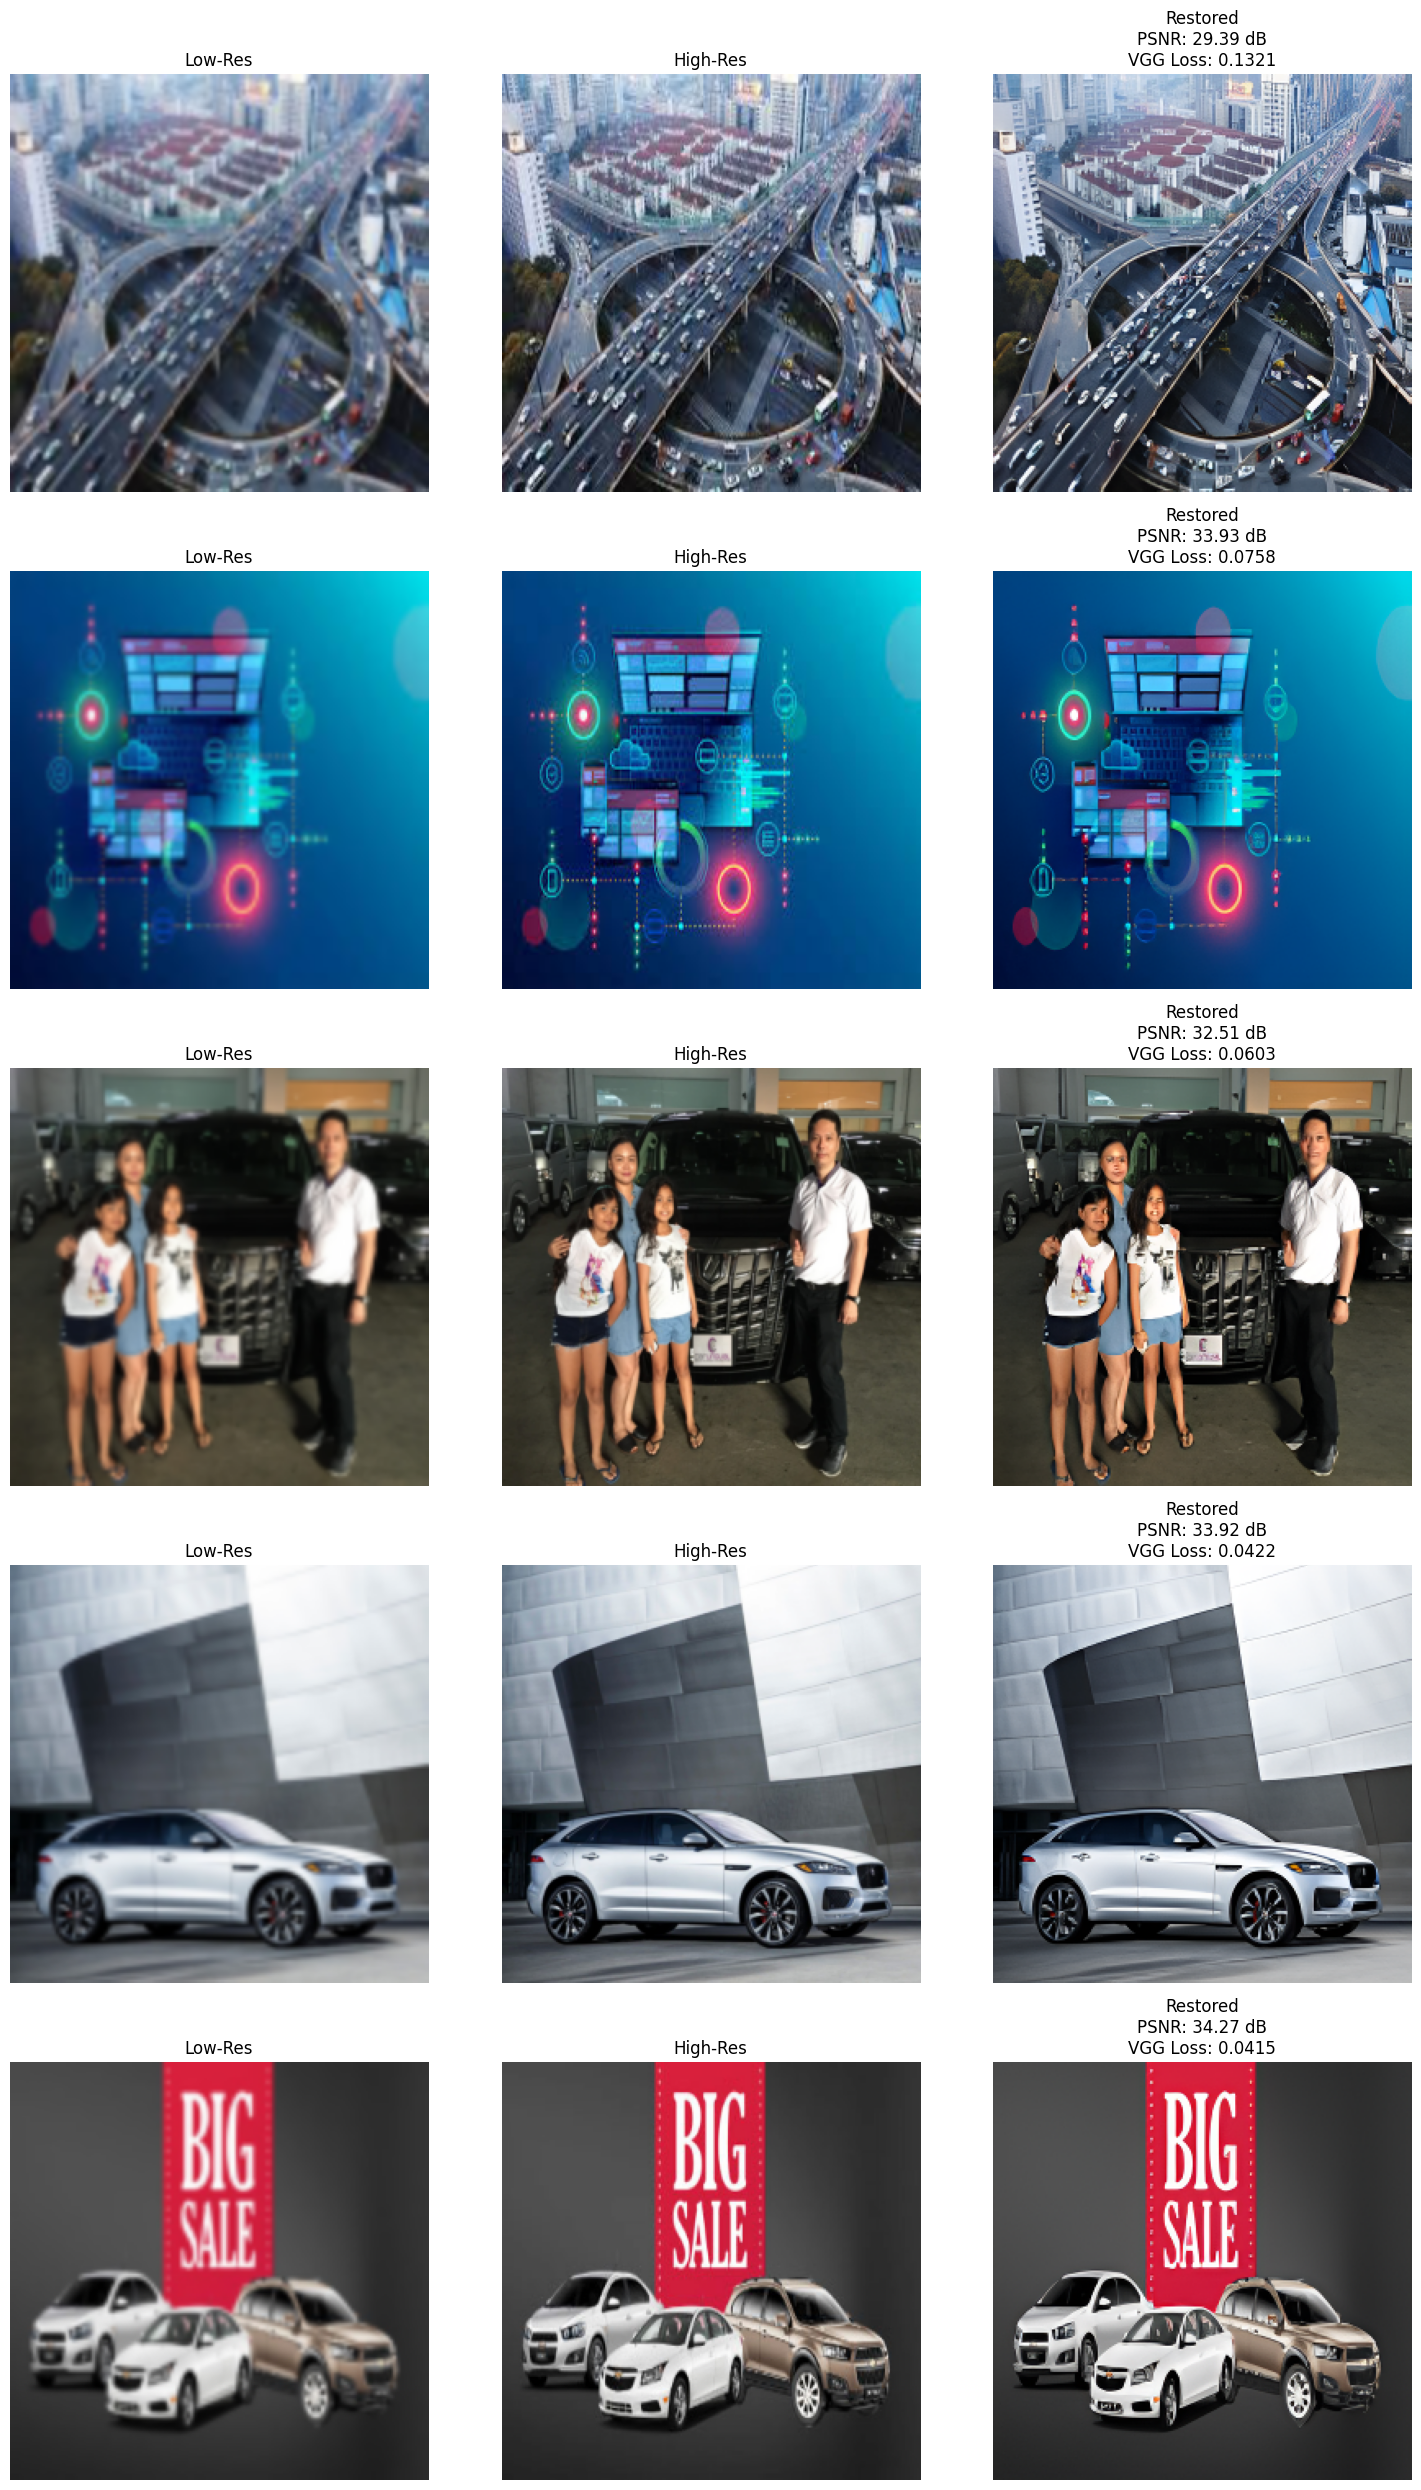

In [24]:


# Get all image filenames
file_names = [f for f in os.listdir(lr_images_dir) if f.endswith('.png')]

# Randomly select 5 images
random_files = random.sample(file_names, 5)

# Create subplots
fig, axes = plt.subplots(5, 3, figsize=(15, 25))

for i, file_name in enumerate(random_files):
    # Load images
    lr_image_path = os.path.join(lr_images_dir, file_name)
    hr_image_path = os.path.join(hr_images_dir, file_name)

    lr_image = Image.open(lr_image_path).convert('RGB')
    hr_image = Image.open(hr_image_path).convert('RGB')

    lr_image_tensor = transform(lr_image).unsqueeze(0).to(device)
    hr_image_tensor = transform(hr_image).unsqueeze(0).to(device)

    # Generate super-resolved image
    with torch.no_grad():
        sr_image_tensor = model(lr_image_tensor)

    # Convert tensors to images for visualization
    lr_image_np = lr_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    hr_image_tensor_np = hr_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    sr_image_np = sr_image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)

    # Resize the super-resolved image to match the high-resolution image
    sr_image_np = cv2.resize(sr_image_np, (hr_image_tensor_np.shape[1], hr_image_tensor_np.shape[0]), interpolation=cv2.INTER_CUBIC)

    # Convert back to uint8 and ensure values are in the [0, 255] range
    lr_image_np = (np.clip(lr_image_np, 0, 1) * 255).astype(np.uint8)
    hr_image_np = (np.clip(hr_image_tensor_np, 0, 1) * 255).astype(np.uint8)
    sr_image_np = (np.clip(sr_image_np, 0, 1) * 255).astype(np.uint8)

    # Calculate PSNR
    psnr_value = calculate_psnr(sr_image_np, hr_image_np)
    psnr_values.append(psnr_value)

    # Calculate VGG Loss
    sr_image_tensor_resized = F.interpolate(sr_image_tensor, size=hr_image_tensor.shape[2:], mode='bicubic', align_corners=False)
    vgg_loss_value = vgg_loss(sr_image_tensor_resized, hr_image_tensor).item()
    vgg_losses.append(vgg_loss_value)

    # Display images and scores
    axes[i, 0].imshow(lr_image_np)
    axes[i, 0].set_title('Low-Res')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(hr_image_np)
    axes[i, 1].set_title('High-Res')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(sr_image_np)
    axes[i, 2].set_title(f'Restored\nPSNR: {psnr_value:.2f} dB\nVGG Loss: {vgg_loss_value:.4f}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
